# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
from torchvision import datasets

# Define transform for exploring/viewing and getting
explore_transform = transforms.Compose([transforms.ToTensor()])
exploreset = datasets.CIFAR10("./CIFAR10/", train=True, download=True, transform=explore_transform)
exploreloader = torch.utils.data.DataLoader(exploreset,batch_size=1000)

# Some notes to myself:
# The loader normalizes RGB colors to range from 0 to 1. That is why we need to divide
# by 255 because pytorch expects the images in the range 0 to 1. 
# If we computed the mean and std from "images" directly, it would not be necessary
# ANYWAYS, WE GOTTA USE THE NORMALIZATIONS FROM IMAGENET
#mean = exploreset.train_data.mean(axis=(0,1,2))/255.
#std = exploreset.train_data.std(axis=(0,1,2))/255.

#images, labels = next(iter(exploreloader))
#print(exploreset.train_data.shape, type(exploreset.train_data))
#print(exploreset.train_data[0,:,:,:])
#print(images.numpy().mean(axis=(0,2,3)))
#print(images.numpy().std(axis=(0,2,3)))
#print(mean)

# mean and std from ImageNet (Source: [0.229, 0.224, 0.225])
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


# Define transforms
train_transforms = transforms.Compose([transforms.RandomRotation(50),
                                       # Cropping may actually not be beneficial since
                                       # the images seem quite censored
                                        transforms.RandomResizedCrop(224),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

test_transforms = transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean,std)])



# Create training set and define training dataloader
trainset = datasets.CIFAR10("./CIFAR10/", train=True, download=True, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
                                       

# Create test set and define test dataloader
testset = datasets.CIFAR10("./CIFAR10/", train=False, download=True, transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

Shapes of labels and images: torch.Size([64]) torch.Size([64, 3, 224, 224])
Number of train and test batches 782 157
frog


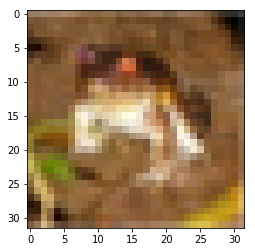

truck


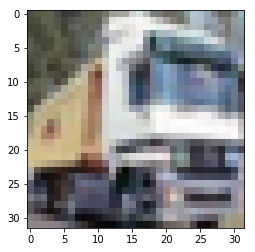

truck


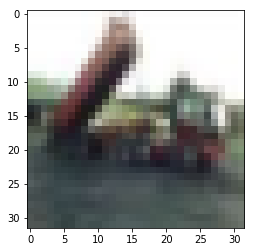

deer


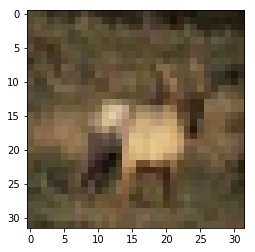

car


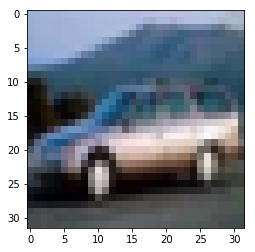

In [32]:
# Explore data
# Check dimensions of test images
images, labels = next(iter(testloader))
print("Shapes of labels and images:", labels.shape,images.shape)
print("Number of train and test batches", len(trainloader), len(testloader))

# Use exploreloader for plotting since 'show5' cannot display test and train images after
# normaliization
show5(exploreloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [6]:
from torchvision import models

device = "cuda"

# Use resnet18 for transfer learning since it is quite 'small' but should be able to yield
# sufficiently accurate results
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Define curstom fc output layers to suit our classification problem
classifier = nn.Sequential(nn.Linear(512,256),nn.ReLU(),nn.Dropout(p=0.2),
                           nn.Linear(256,10),nn.LogSoftmax(dim=1))


# Replace resnet18 output by the one defined above
model.fc = classifier
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 98915132.45it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [7]:
# Use adam optimizer for only optimizing our custom layers
optimizer = optim.Adam(model.fc.parameters(),lr=0.001)
# Negativ log likelihood loss should be appropriate
criterion = nn.NLLLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [8]:
epochs = 5
train_losses_epoch = []
train_losses_batch = []
validation_losses = []

# No validation during training since it is expensive. 
# After the training loop we do validate our optimized model on the test set anyways
lvalidate = False

istep = 0
iprint = 50
for epoch in range(epochs):
    
    running_loss = 0.
    
    for images, labels in trainloader:
        # Move data to GPU
        images, labels = (images.to(device), labels.to(device))
        
        optimizer.zero_grad()
        
        logps = model.forward(images)
        loss = criterion(logps,labels)
        loss.backward()
        
        optimizer.step()
        running_loss += loss.item()
        
        train_losses_batch.append(loss.item())
        
        istep += 1
        if istep%iprint==0: print("Epoch, Step, Loss", epoch, istep, loss.item())
            
        if istep%iprint == 0 and lvalidate:
            validation_loss = 0
            acc = 0.
            
            model.eval()
            with torch.no_grad():
                for images, labels in testloader:
                    logps = model.forward(images)
                    ps = torch.exp(logps)
                    loss = criterion(logps,labels)
                    
                    validation_loss += loss.item()
                    
                    top_class = ps.topk(1,dim=1)[1]
                    n_tptn = top_class == labels.view(*top_class.shape)
                    acc += torch.mean(n_tptn.type(torch.FloatTensor)).item()
            model.train()
            
            print("Epoch, istep",epoch+1, istep)
            print("Accuracy [%]: ", acc/len(testloader)*100)
            print("Train loss: ", running_loss/(iprint*istep) )
            print("Validation loss", validation_loss/len(testloader))
    else:
        train_losses_epoch.append(running_loss/len(trainloader))
        print("Epoch " + str(epoch) + "train loss: ",running_loss/len(trainloader))
                    
        

Epoch, Step, Loss 0 50 1.9975132942199707
Epoch, Step, Loss 0 100 1.8779526948928833
Epoch, Step, Loss 0 150 1.6426388025283813
Epoch, Step, Loss 0 200 1.6086868047714233
Epoch, Step, Loss 0 250 1.6815741062164307
Epoch, Step, Loss 0 300 1.6945602893829346
Epoch, Step, Loss 0 350 1.7463963031768799
Epoch, Step, Loss 0 400 1.477306842803955
Epoch, Step, Loss 0 450 1.6170341968536377
Epoch, Step, Loss 0 500 1.8132219314575195
Epoch, Step, Loss 0 550 1.4548739194869995
Epoch, Step, Loss 0 600 1.5398826599121094
Epoch, Step, Loss 0 650 1.5795918703079224
Epoch, Step, Loss 0 700 1.707503080368042
Epoch, Step, Loss 0 750 1.5087107419967651
Epoch 0train loss:  1.674300506596675
Epoch, Step, Loss 1 800 1.613783836364746
Epoch, Step, Loss 1 850 1.5610647201538086
Epoch, Step, Loss 1 900 1.5270414352416992
Epoch, Step, Loss 1 950 1.5678815841674805
Epoch, Step, Loss 1 1000 1.6348342895507812
Epoch, Step, Loss 1 1050 1.4073970317840576
Epoch, Step, Loss 1 1100 1.5848835706710815
Epoch, Step, Loss

Plot the training loss (and validation loss/accuracy, if recorded).

([<matplotlib.axis.XTick at 0x7f4034f9dba8>,
 <a list of 5 Text xticklabel objects>)

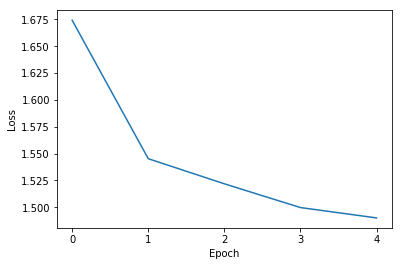

In [29]:
## YOUR CODE HERE ##
plt.plot(range(len(train_losses_epoch)),train_losses_epoch)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.xticks([0,1,2,3,4])

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [13]:
## YOUR CODE HERE ##
running_loss = 0.
acc = 0.
   
# Turn off dropout (evaluation model)
model.eval()

with torch.no_grad():
    for images, labels in testloader:
        images, labels = (images.to(device), labels.to(device))
        logps = model.forward(images)
        ps = torch.exp(logps)
        loss = criterion(logps,labels)
                    
        running_loss += loss.item()
                    
        top_class = ps.topk(1,dim=1)[1]
        n_tptn = top_class == labels.view(*top_class.shape)
        acc += torch.mean(n_tptn.type(torch.FloatTensor)).item()
           
            
print("Accuracy [%]: ", acc/len(testloader)*100)
print("Validation/Test Loss", running_loss/len(testloader))

Accuracy [%]:  67.90406050955414
Validation/Test Loss 0.9194602548696433


## Saving your model
Using `torch.save`, save your model for future loading.

In [26]:
## YOUR CODE HERE ##
checkpoint = {'inputs': 224*224*3,
              'layer1': model.layer1,
              'layer2': model.layer2,
              'layer3': model.layer3,
              'layer4': model.layer4,
              'fc': model.fc,
              'outputs': 10,
              'state_dict': model.state_dict()}
torch.save(checkpoint, 'checkpoint.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

<ul>
    <li> I just used transfer learning on a publicly available model and without much 
        finetuning and even with without fully converging the model, I achieved an
        accuracy of roughly 68 %. This is only 2 % less than the accuracy of Detectocorp's
        model. I do not think that we should to pay for their model as we could easily
        get an accuracy  of 70 %  without having to spend much time on that.
         </li>
    <li> I just trained the last layer of the model. If we optimized more of layers, like 
        e.g. some of the input layers, potentially used a bigger model 
        let it train a bit longer and did some more 
        hyperparameter tuning, we could achieve even better accuracy than Detectocorp's
        model. But if we say, 70 % is what we aim for, we could also just use my model
        as it is since there is only aa 2 % difference between the two, which I doubt
        would be significant for our purpose</li>
    <li> Obviously, there are some better model's in the recent literature, which show an
        accuracy of about 99 %, which is far better than my model. 
        But if we could afford some more GPU hours to use transfer
        learning on a bigger model like ResNet50 and fine-tuned the entire model (all
        layers), we could probably get an accuracy of over 90 %.  </li>
    <li> Anyways, in my opinion buying Detectocorp's model should not be an option, given
        the fact that I achieved the same accuracy within a bit more than a afternoon
        of work.</li>
</ul>

## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).